In [1]:
# Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Sklearn model selection & evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    mean_squared_error, mean_absolute_error, r2_score, roc_auc_score
)

# Sklearn preprocessing & pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Sklearn models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

# Sklearn datasets
from sklearn.datasets import fetch_openml

# For decision boundary visualization
from matplotlib.colors import ListedColormap


# Tutorial Session - 5

## Plan

* Three conceptual questions.
* Solve example data sets on KNN regression, Classification, and using learning curves to choose the
value of ‘K’.

## Load Auto data-set (Ref: ISLP)

In [13]:
# Load Auto dataset with fallback options
try:
    from ISLP import load_data
    Auto = load_data('Auto')
    print("Loaded Auto dataset from ISLP package.")
except ImportError:
    try:
        import subprocess, sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "ISLP"])
        from ISLP import load_data
        Auto = load_data('Auto')
        print("Installed ISLP and loaded Auto dataset.")
    except Exception as e:
        print("ISLP not available. Downloading dataset from web...")
        import pandas as pd
        url = "https://raw.githubusercontent.com/intro-stat-learning/ISLP/refs/heads/main/ISLP/data/Auto.csv"
        Auto = pd.read_csv(url, na_values='?').dropna()
        print("Loaded Auto dataset from GitHub.")
        
print(Auto.columns)


Loaded Auto dataset from ISLP package.
Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin'],
      dtype='object')


In [3]:
Auto.describe().iloc[:,:]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


# A1. Exploratory Data Analysis (EDA) on Auto Dataset

We explore how fuel efficiency (`mpg`) relates to all predictors.

### 1. Distribution of MPG
- Plot histogram to see how mpg is spread across cars.

### 2. Pairwise Scatterplots (mpg vs predictors)
- Displacement, horsepower, weight → strong negative relation.
- Cylinders → step-like pattern (fewer cylinders → higher mpg).
- Year → clear upward trend (newer cars are more efficient).
- Acceleration → weak relation.
- Origin → regional clusters.

### 3. Correlation Heatmap
- Strongest negative: weight vs mpg.
- Positive: year vs mpg.
- Others weaker or redundant.

---

### Motivation
- **Linear regression**: good for capturing *global trends* (e.g., mpg rising with year).
- **KNN regression**: good for capturing *local patterns* (e.g., clusters by origin).
- **Classification setup**: binarize mpg (high/low) to study bias–variance.

---

**Optional / Experiment**
- Try boxplots of mpg by origin.
- Try `sns.pairplot` for a subset of predictors.


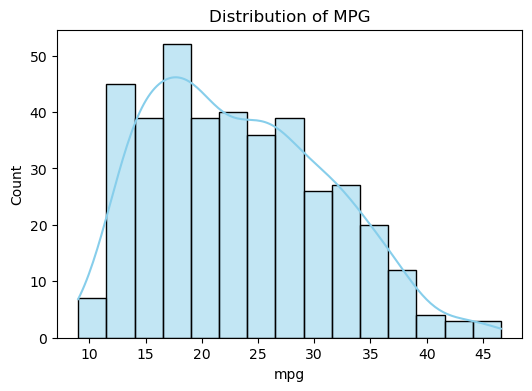

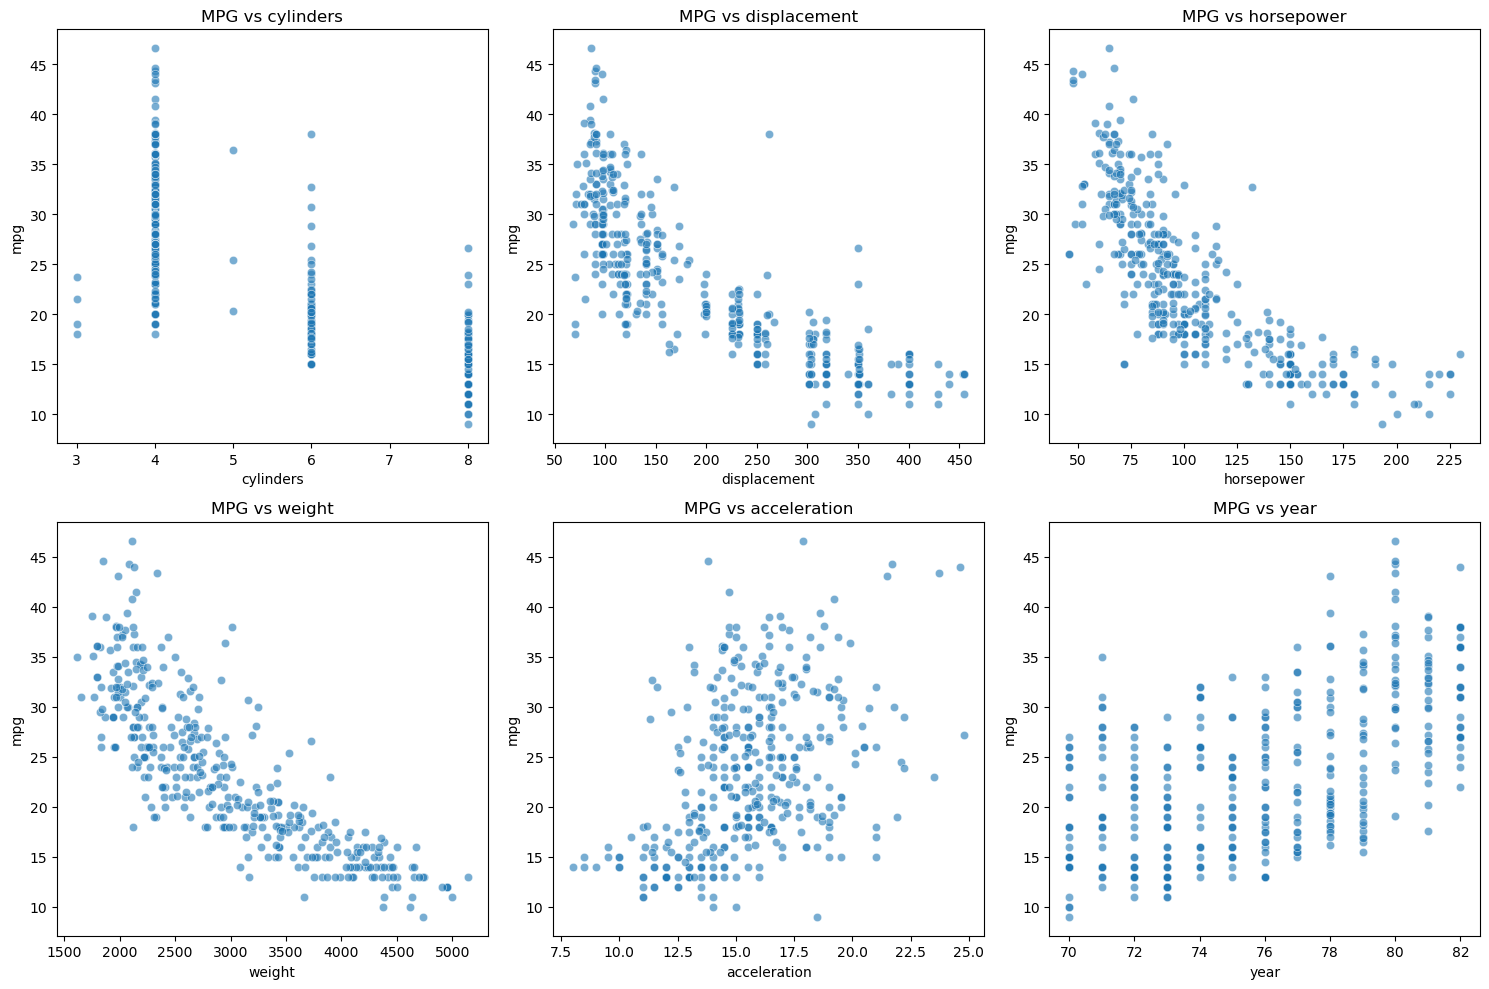

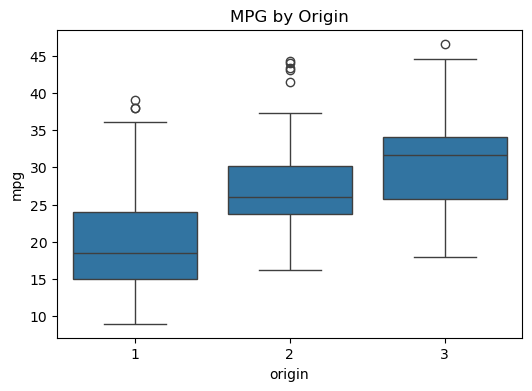

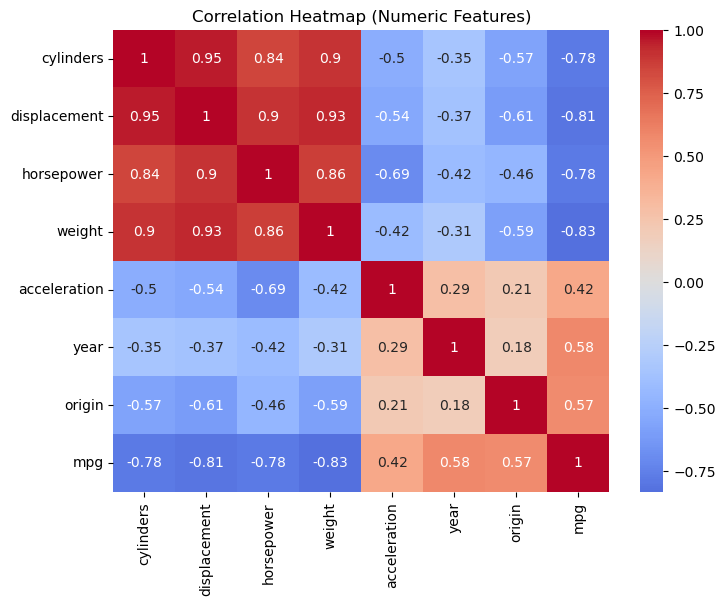

In [4]:


# Keep relevant columns
features = ["cylinders", "displacement", "horsepower", "weight", "acceleration", "year", "origin"]

# 1. Distribution of mpg
plt.figure(figsize=(6,4))
sns.histplot(Auto['mpg'], bins=15, kde=True, color="skyblue")
plt.title("Distribution of MPG")
plt.xlabel("mpg")
plt.ylabel("Count")
plt.show()

# 2. Scatterplots: mpg vs each predictor
fig, axes = plt.subplots(2, 3, figsize=(15,10))
for ax, col in zip(axes.flat, features[:-1]):  # exclude 'origin' for scatter since categorical-like
    sns.scatterplot(data=Auto, x=col, y="mpg", ax=ax, alpha=0.6)
    ax.set_title(f"MPG vs {col}")
plt.tight_layout()
plt.show()

# 2b. Boxplot for origin (categorical-like)
plt.figure(figsize=(6,4))
sns.boxplot(data=Auto, x="origin", y="mpg")
plt.title("MPG by Origin")
plt.show()

# 3. Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(Auto[features + ["mpg"]].corr(numeric_only=True), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


# A2. Linear vs KNN Regression (1D and 2D)

From EDA, we saw strong negative correlations between `mpg` and:
- **weight**
- **displacement**

These features are natural candidates to test:

- **Linear Regression**  
  - Fits a straight line (1D) or plane (2D).  
  - Works if the trend is mostly linear.  

- **KNN Regression**  
  - Predicts as the average of nearby neighbors.  
  - Flexible, captures local trends.  
  - Can overfit when K is small, underfit when K is large.  

---

### Plan
1. Use **1D** (`weight` and `displacement`) and **2D** (`weight + displacement`) predictors.  
2. Train/test split for consistent evaluation.  
3. Fit both Linear and KNN models.  
4. Compare metrics: RMSE, MAE, R².  
5. For 1D: visualize fitted line vs KNN smoother.  
6. For 2D: just compare metrics (visualization harder).  

---

### Key Questions
- When does KNN outperform Linear?  
- How do the errors change from 1D to 2D?  
- Where do we see signs of bias–variance tradeoff?  

---

**Optional / Experiment**
- Try different values of `k` (e.g., 5, 10, 50) to see bias–variance in action.  
- Add another predictor (e.g., `horsepower`) and repeat 2D regression.  
- Plot residuals (`y_true - y_pred`) for each model.  


=== 1D Regression: weight → mpg ===
Linear Train: {'RMSE': 4.36, 'MAE': 3.29, 'R2': 0.698}
Linear Test : {'RMSE': 4.21, 'MAE': 3.46, 'R2': 0.653}
KNN Train   : {'RMSE': 4.08, 'MAE': 3.07, 'R2': 0.736}
KNN Test    : {'RMSE': 4.16, 'MAE': 3.13, 'R2': 0.661}


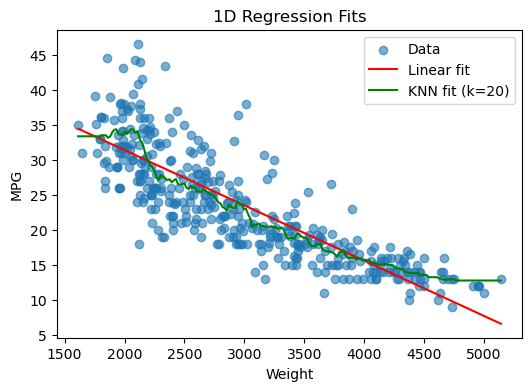

=== 1D Regression: displacement → mpg ===
Linear Train: {'RMSE': 4.64, 'MAE': 3.5, 'R2': 0.659}
Linear Test : {'RMSE': 4.61, 'MAE': 3.69, 'R2': 0.584}
KNN Train   : {'RMSE': 3.93, 'MAE': 2.86, 'R2': 0.755}
KNN Test    : {'RMSE': 4.54, 'MAE': 3.34, 'R2': 0.597}


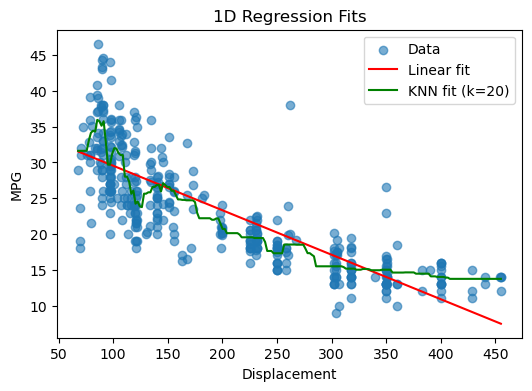


=== 2D Regression: (weight, displacement) → mpg ===
Linear Train: {'RMSE': 4.29, 'MAE': 3.26, 'R2': 0.708}
Linear Test : {'RMSE': 4.28, 'MAE': 3.49, 'R2': 0.641}
KNN Train   : {'RMSE': 3.71, 'MAE': 2.69, 'R2': 0.782}
KNN Test    : {'RMSE': 4.51, 'MAE': 3.37, 'R2': 0.602}


In [5]:


# Target
y = Auto["mpg"]

# Helper: compute metrics
def regression_metrics(y_true, y_pred):
    return {
        "RMSE": round(np.sqrt(mean_squared_error(y_true, y_pred)), 2),
        "MAE":  round(mean_absolute_error(y_true, y_pred), 2),
        "R2":   round(r2_score(y_true, y_pred), 3)
    }

# ========================
# 1D Regression: weight → mpg
# ========================
X1 = Auto[["weight"]]
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

lin1 = LinearRegression().fit(X1_train, y_train)
knn1 = Pipeline([
    ("scaler", StandardScaler()), 
    ("knn", KNeighborsRegressor(n_neighbors=20))
]).fit(X1_train, y_train)

print("=== 1D Regression: weight → mpg ===")
print("Linear Train:", regression_metrics(y_train, lin1.predict(X1_train)))
print("Linear Test :", regression_metrics(y_test,  lin1.predict(X1_test)))
print("KNN Train   :", regression_metrics(y_train, knn1.predict(X1_train)))
print("KNN Test    :", regression_metrics(y_test,  knn1.predict(X1_test)))

# Plot fits
plt.figure(figsize=(6,4))
plt.scatter(X1, y, alpha=0.6, label="Data")
x_grid = np.linspace(X1.min(), X1.max(), 200).reshape(-1,1)
plt.plot(x_grid, lin1.predict(x_grid), color="red", label="Linear fit")
plt.plot(x_grid, knn1.predict(x_grid), color="green", label="KNN fit (k=20)")
plt.xlabel("Weight"); plt.ylabel("MPG"); plt.title("1D Regression Fits")
plt.legend(); plt.show()

# ========================
# 1D Regression: displacement → mpg
# ========================
X1 = Auto[["displacement"]]
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

lin1 = LinearRegression().fit(X1_train, y_train)
knn1 = Pipeline([
    ("scaler", StandardScaler()), 
    ("knn", KNeighborsRegressor(n_neighbors=20))
]).fit(X1_train, y_train)

print("=== 1D Regression: displacement → mpg ===")
print("Linear Train:", regression_metrics(y_train, lin1.predict(X1_train)))
print("Linear Test :", regression_metrics(y_test,  lin1.predict(X1_test)))
print("KNN Train   :", regression_metrics(y_train, knn1.predict(X1_train)))
print("KNN Test    :", regression_metrics(y_test,  knn1.predict(X1_test)))

# Plot fits
plt.figure(figsize=(6,4))
plt.scatter(X1, y, alpha=0.6, label="Data")
x_grid = np.linspace(X1.min(), X1.max(), 200).reshape(-1,1)
plt.plot(x_grid, lin1.predict(x_grid), color="red", label="Linear fit")
plt.plot(x_grid, knn1.predict(x_grid), color="green", label="KNN fit (k=20)")
plt.xlabel("Displacement"); plt.ylabel("MPG"); plt.title("1D Regression Fits")
plt.legend(); plt.show()

# =============================
# 2D Regression: (weight, displacement) → mpg
# =============================
X2 = Auto[["weight", "displacement"]]
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

lin2 = LinearRegression().fit(X2_train, y_train)
knn2 = Pipeline([
    ("scaler", StandardScaler()), 
    ("knn", KNeighborsRegressor(n_neighbors=10))
]).fit(X2_train, y_train)

print("\n=== 2D Regression: (weight, displacement) → mpg ===")
print("Linear Train:", regression_metrics(y_train, lin2.predict(X2_train)))
print("Linear Test :", regression_metrics(y_test,  lin2.predict(X2_test)))
print("KNN Train   :", regression_metrics(y_train, knn2.predict(X2_train)))
print("KNN Test    :", regression_metrics(y_test,  knn2.predict(X2_test)))


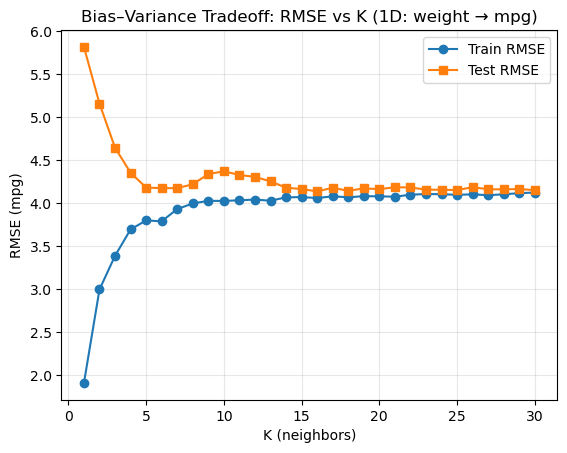

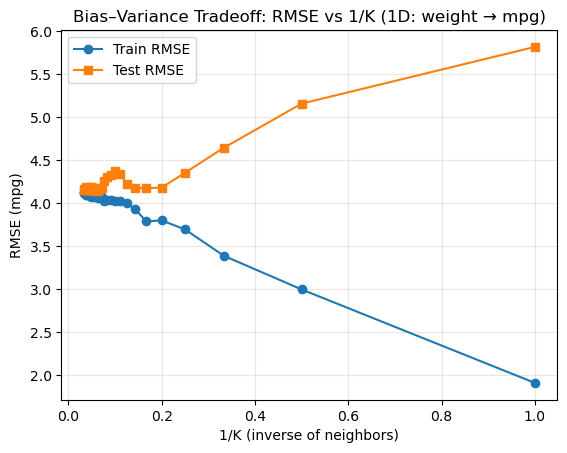

In [6]:


X = Auto[["weight"]].values
y = Auto["mpg"].values
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

Ks = list(range(1, 31))
train_rmse, test_rmse = [], []

for k in Ks:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsRegressor(n_neighbors=k))
    ])
    pipe.fit(X_tr, y_tr)
    yhat_tr = pipe.predict(X_tr)
    yhat_te = pipe.predict(X_te)
    train_rmse.append(np.sqrt(mean_squared_error(y_tr, yhat_tr)))
    test_rmse.append(np.sqrt(mean_squared_error(y_te, yhat_te)))
plt.figure()
plt.plot(Ks, train_rmse, marker="o", label="Train RMSE")
plt.plot(Ks, test_rmse, marker="s", label="Test RMSE")
plt.xlabel("K (neighbors)")
plt.ylabel("RMSE (mpg)")
plt.title("Bias–Variance Tradeoff: RMSE vs K (1D: weight → mpg)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.plot([1/k for k in Ks], train_rmse, marker="o", label="Train RMSE")
plt.plot([1/k for k in Ks], test_rmse, marker="s", label="Test RMSE")
plt.xlabel("1/K (inverse of neighbors)")
plt.ylabel("RMSE (mpg)")
plt.title("Bias–Variance Tradeoff: RMSE vs 1/K (1D: weight → mpg)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# B1. Classification on Auto: Logistic vs KNN

We convert `mpg` into a binary target:  
- **High MPG** = `mpg > median`.

**Why Logistic?**  
- A simple, interpretable linear classifier (baseline).  

**Why KNN?**  
- Flexible, captures curved boundaries.  
- Useful for datasets with clusters or nonlinearity.  

---

### Plan
1. Use 2 predictors: `weight`, `displacement` (chosen from EDA).  
2. Train/test split with stratification.  
3. Fit **Logistic Regression** and **KNN (K=25)**.  
4. Report metrics: Accuracy, Precision, Recall, F1, Confusion Matrix.  
5. Plot decision boundaries to visualize how each method separates the classes.  

---

### Key Questions
- Does Logistic’s straight-line boundary perform well enough?  
- Does KNN capture more curved, flexible boundaries?  
- Which metrics improve (or degrade) when switching from linear → local?  

---

**Optional / Experiment**
- Try smaller K (e.g., K=1, K=5) vs larger K (e.g., K=50).  
- Swap features: (`weight`, `year`) instead of (`weight`, `displacement`).  
- Plot confusion matrix with `sns.heatmap` for clearer visualization.  



=== Logistic (2D) ===
Accuracy : 0.886
Precision: 0.857
Recall   : 0.923
F1       : 0.889
Confusion Matrix:
 [[34  6]
 [ 3 36]]

=== KNN (2D, K=25) ===
Accuracy : 0.911
Precision: 0.864
Recall   : 0.974
F1       : 0.916
Confusion Matrix:
 [[34  6]
 [ 1 38]]


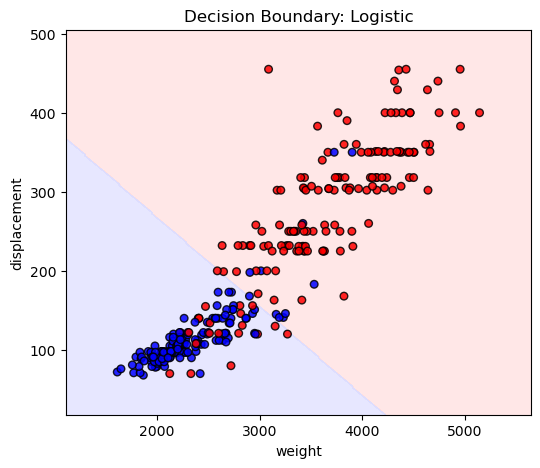

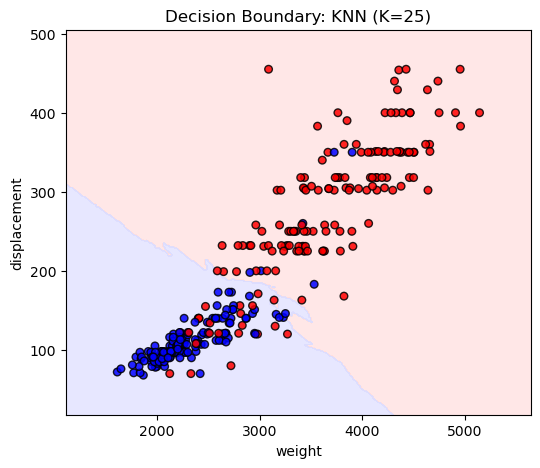

In [7]:

# ----- Binary target
dfc = Auto.dropna().copy()
dfc["high_mpg"] = (dfc["mpg"] > dfc["mpg"].median()).astype(int)

X2 = dfc[["weight","displacement"]].values
y  = dfc["high_mpg"].values

# Train/test split (stratified for balance)
X_tr, X_te, y_tr, y_te = train_test_split(
    X2, y, test_size=0.2, random_state=42, stratify=y
)

# ----- Models
log_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("log", LogisticRegression(max_iter=1000))
]).fit(X_tr, y_tr)

knn_k = 25  # change this to try different K
knn_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=knn_k))
]).fit(X_tr, y_tr)

# ----- Metrics
def report_metrics(name, model):
    y_pred = model.predict(X_te)
    print(f"\n=== {name} ===")
    print("Accuracy :", round(accuracy_score(y_te, y_pred), 3))
    print("Precision:", round(precision_score(y_te, y_pred), 3))
    print("Recall   :", round(recall_score(y_te, y_pred), 3))
    print("F1       :", round(f1_score(y_te, y_pred), 3))
    print("Confusion Matrix:\n", confusion_matrix(y_te, y_pred))

report_metrics("Logistic (2D)", log_clf)
report_metrics(f"KNN (2D, K={knn_k})", knn_clf)

# ----- Decision boundary plot util
def plot_decision_boundary_2d(model, X_train, y_train, title):
    x_min, x_max = X_train[:, 0].min() - 500, X_train[:, 0].max() + 500
    y_min, y_max = X_train[:, 1].min() - 50,  X_train[:, 1].max() + 50
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    cmap_light = ListedColormap(["#FFDDDD", "#DDDDFF"])
    cmap_bold  = ListedColormap(["#FF0000", "#0000FF"])

    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.7)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold,
                edgecolor='k', s=30, alpha=0.85)
    plt.xlabel("weight")
    plt.ylabel("displacement")
    plt.title(title)
    plt.show()

# Plot boundaries
plot_decision_boundary_2d(log_clf, X_tr, y_tr, "Decision Boundary: Logistic")
plot_decision_boundary_2d(knn_clf, X_tr, y_tr, f"Decision Boundary: KNN (K={knn_k})")


### Bias–Variance Tradeoff across Dimensions

We repeat the KNN regression learning curves using **1D, 2D, and 3D feature sets**.  
This shows how adding dimensions increases variance and noise (curse of dimensionality),  
making it harder for KNN to generalize as K varies.  


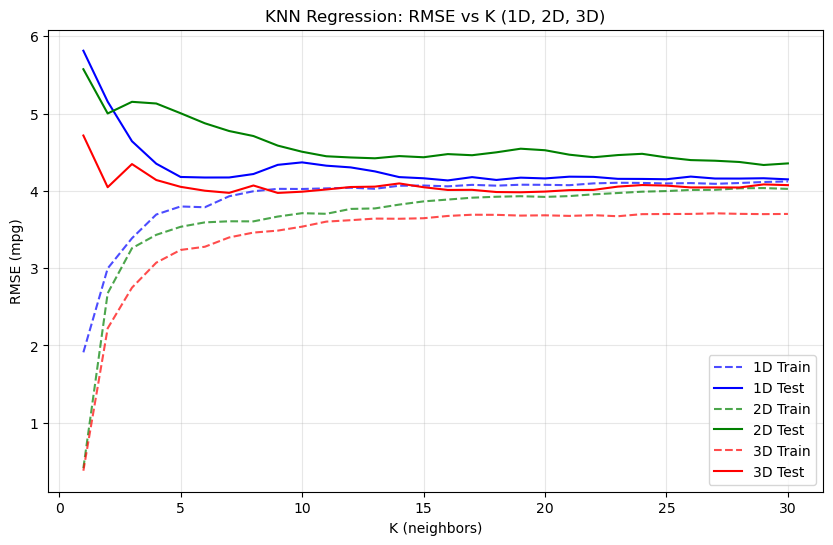

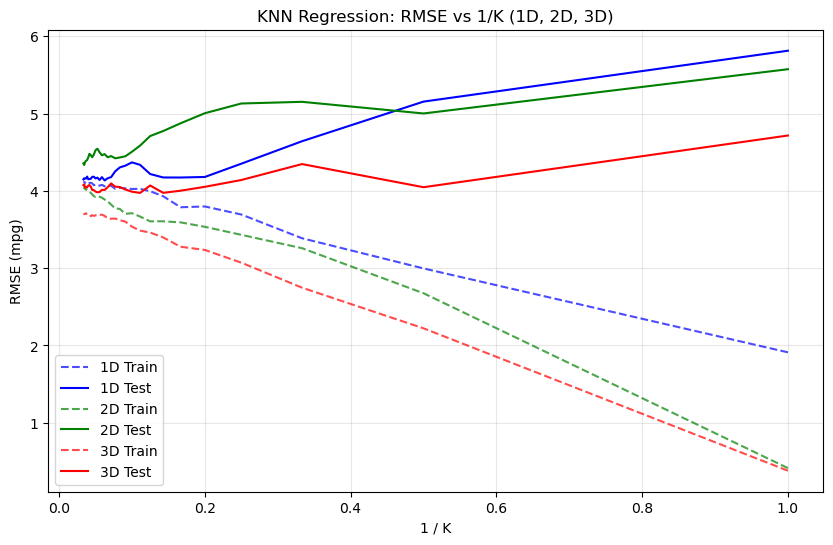

In [8]:


# Features and target
y = Auto["mpg"].values
X1 = Auto[["weight"]].values
X2 = Auto[["weight","displacement"]].values
X3 = Auto[["weight","displacement","horsepower"]].values

# Split
splits = {}
for name, X in [("1D", X1), ("2D", X2), ("3D", X3)]:
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
    splits[name] = (X_tr, X_te, y_tr, y_te)

Ks = list(range(1, 31))
results = {dim: {"train": [], "test": []} for dim in splits}

# Sweep over K
for dim, (X_tr, X_te, y_tr, y_te) in splits.items():
    for k in Ks:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("knn", KNeighborsRegressor(n_neighbors=k))
        ])
        pipe.fit(X_tr, y_tr)
        yhat_tr = pipe.predict(X_tr)
        yhat_te = pipe.predict(X_te)
        train_rmse = np.sqrt(mean_squared_error(y_tr, yhat_tr))
        test_rmse  = np.sqrt(mean_squared_error(y_te, yhat_te))
        results[dim]["train"].append(train_rmse)
        results[dim]["test"].append(test_rmse)

# Plot RMSE vs K
plt.figure(figsize=(10,6))
for dim, color in zip(results, ["blue","green","red"]):
    plt.plot(Ks, results[dim]["train"], "--", label=f"{dim} Train", color=color, alpha=0.7)
    plt.plot(Ks, results[dim]["test"], "-", label=f"{dim} Test", color=color)
plt.xlabel("K (neighbors)")
plt.ylabel("RMSE (mpg)")
plt.title("KNN Regression: RMSE vs K (1D, 2D, 3D)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot RMSE vs 1/K
plt.figure(figsize=(10,6))
invK = [1/k for k in Ks]
for dim, color in zip(results, ["blue","green","red"]):
    plt.plot(invK, results[dim]["train"], "--", label=f"{dim} Train", color=color, alpha=0.7)
    plt.plot(invK, results[dim]["test"], "-", label=f"{dim} Test", color=color)
plt.xlabel("1 / K")
plt.ylabel("RMSE (mpg)")
plt.title("KNN Regression: RMSE vs 1/K (1D, 2D, 3D)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### Alternate Predictor Choice: Year

Repeating EDA with `high_mpg` as the binary target, we compare predictors via boxplots.  
Most variables (weight, displacement, horsepower) show clear separation between low/high mpg.  
For `year`, however, the boxplots **overlap** — but the trend from earlier EDA suggested newer cars have better mpg.  

👉 Even though the separation looks weak, we will test `year` as a predictor to see:  
- Can Logistic Regression capture the upward trend?  
- Does KNN classification adapt differently when the boundary is less distinct?  


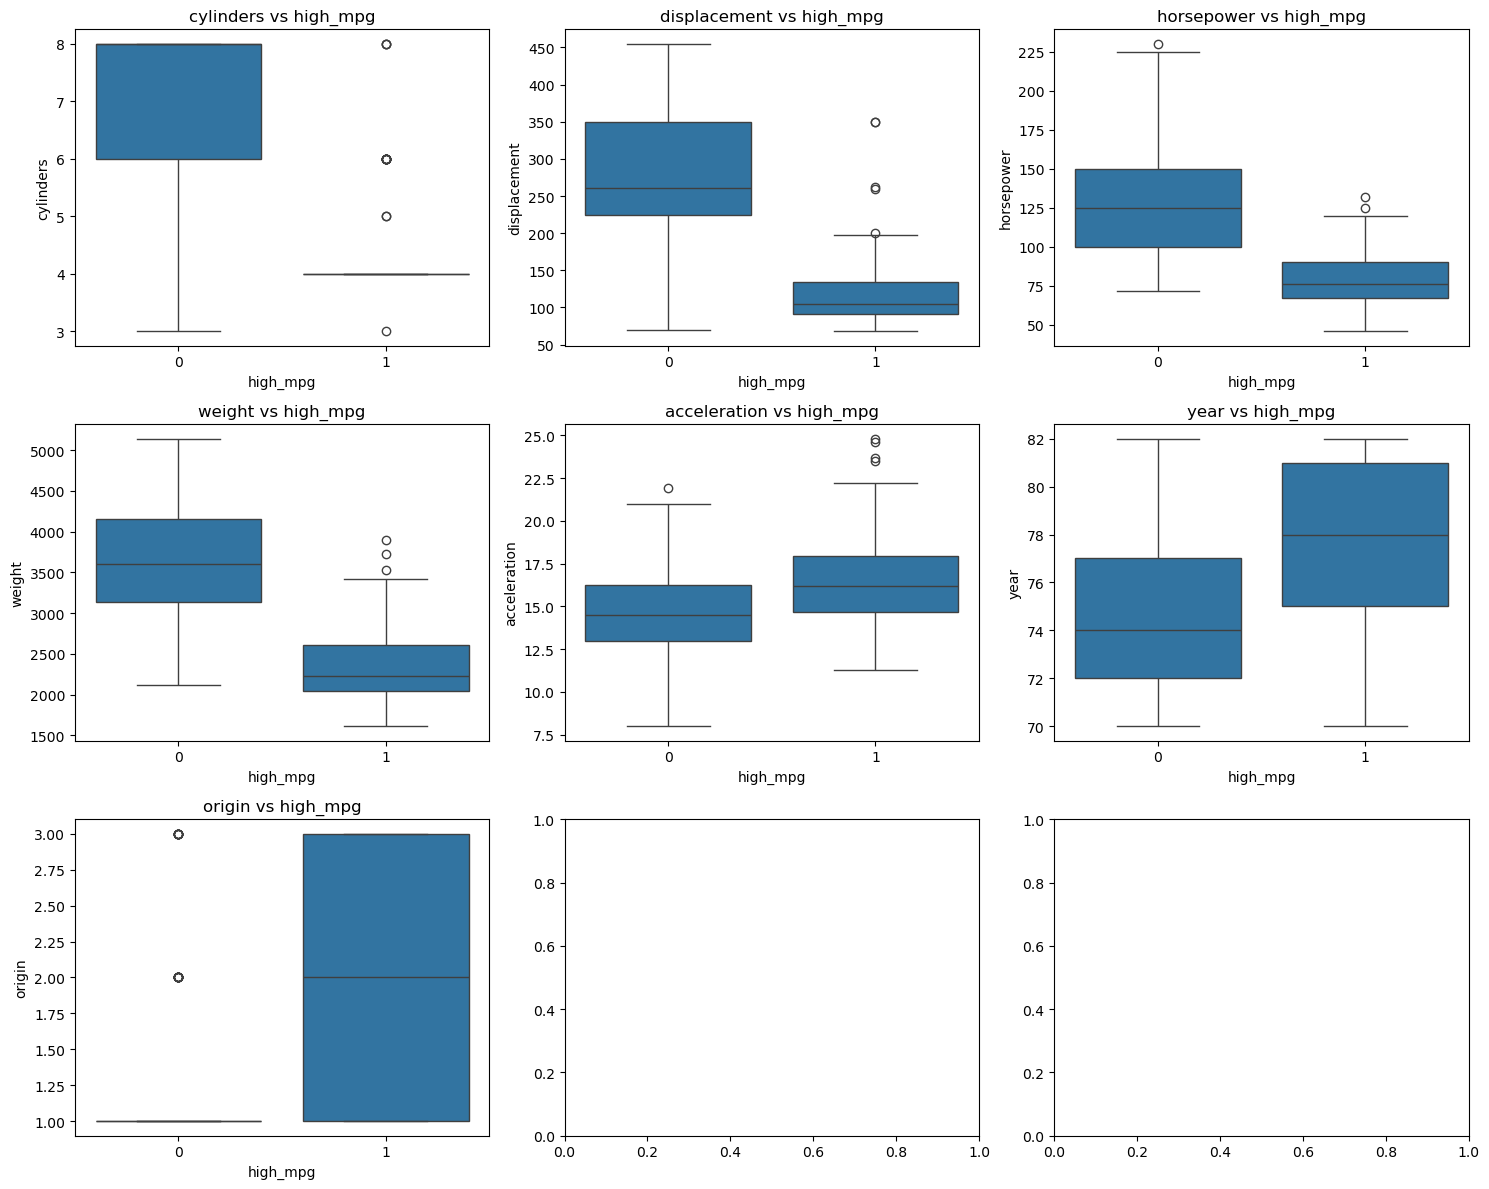

In [9]:


# Binary label
Auto["high_mpg"] = (Auto["mpg"] > Auto["mpg"].median()).astype(int)

predictors = ["cylinders","displacement","horsepower","weight","acceleration","year","origin"]

# Boxplots of each predictor vs high_mpg
fig, axes = plt.subplots(3, 3, figsize=(15,12))
axes = axes.flatten()
for i, col in enumerate(predictors):
    sns.boxplot(data=Auto, x="high_mpg", y=col, ax=axes[i])
    axes[i].set_title(f"{col} vs high_mpg")
plt.tight_layout()
plt.show()


###  Adding `year`
1. `Year` shows an overall upward trend with mpg, but weak separation between high/low mpg.  
2. Adding it to KNN (3D) increases variance — neighborhoods get sparse, curves become noisy.  
3. More features ≠ always better: useful for linear models (global trend), but can hurt local methods like KNN.  


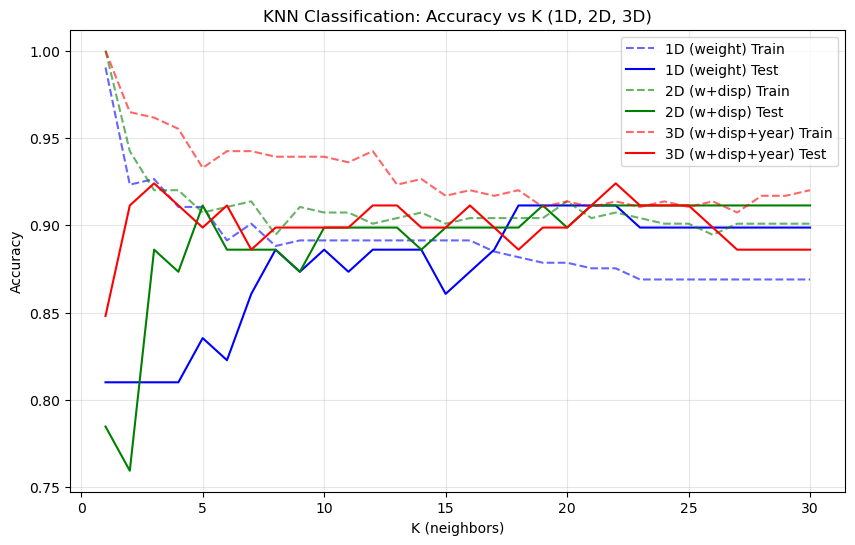

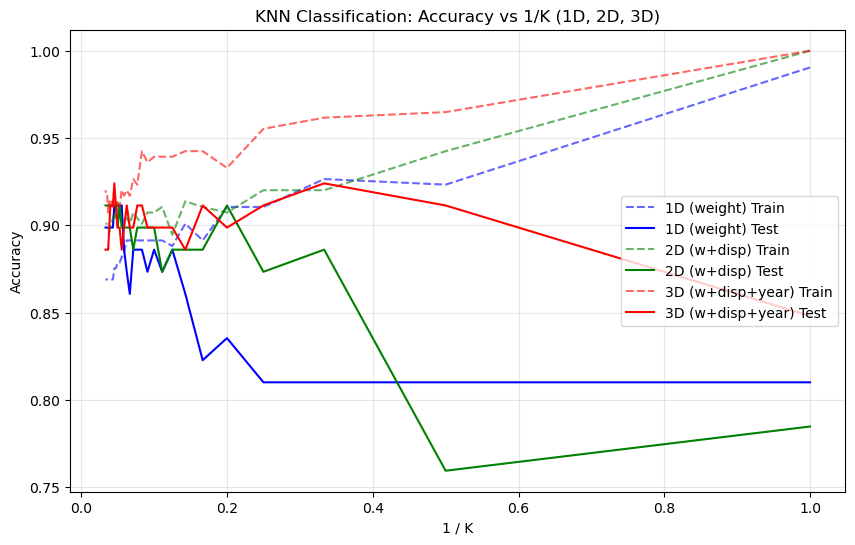

In [10]:

# Label
y = Auto["high_mpg"].values

# Feature sets
X1 = Auto[["weight"]].values
X2 = Auto[["weight","displacement"]].values
X3 = Auto[["weight","displacement","year"]].values

splits = {}
for name, X in [("1D (weight)", X1), ("2D (w+disp)", X2), ("3D (w+disp+year)", X3)]:
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    splits[name] = (X_tr, X_te, y_tr, y_te)

Ks = list(range(1, 31))
results = {dim: {"train": [], "test": []} for dim in splits}

# Sweep
for dim, (X_tr, X_te, y_tr, y_te) in splits.items():
    for k in Ks:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier(n_neighbors=k))
        ])
        pipe.fit(X_tr, y_tr)
        results[dim]["train"].append(accuracy_score(y_tr, pipe.predict(X_tr)))
        results[dim]["test"].append(accuracy_score(y_te, pipe.predict(X_te)))

# Plot Accuracy vs K
plt.figure(figsize=(10,6))
for dim, color in zip(results, ["blue","green","red"]):
    plt.plot(Ks, results[dim]["train"], "--", label=f"{dim} Train", color=color, alpha=0.6)
    plt.plot(Ks, results[dim]["test"], "-", label=f"{dim} Test", color=color)
plt.xlabel("K (neighbors)")
plt.ylabel("Accuracy")
plt.title("KNN Classification: Accuracy vs K (1D, 2D, 3D)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot Accuracy vs 1/K
plt.figure(figsize=(10,6))
invK = [1/k for k in Ks]
for dim, color in zip(results, ["blue","green","red"]):
    plt.plot(invK, results[dim]["train"], "--", label=f"{dim} Train", color=color, alpha=0.6)
    plt.plot(invK, results[dim]["test"], "-", label=f"{dim} Test", color=color)
plt.xlabel("1 / K")
plt.ylabel("Accuracy")
plt.title("KNN Classification: Accuracy vs 1/K (1D, 2D, 3D)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## B2. Adult Income Dataset (Large-Scale Classification)

So far, Auto data was small and fairly clean. To stress-test KNN and Logistic Regression,  
we now use the **Adult Income dataset** (`>50K` vs `<=50K`).  

### Why this dataset?
- **High dimensionality:** many categorical + numeric features.  
- **Class imbalance:** fewer high-income cases.  
- **Scale:** >45k samples in full (we downsample to 5k for demo speed).  

### Demo Plan
1. Preprocess features (numeric → scaled, categorical → one-hot).  
2. Train KNN for different K and plot train/test accuracy.  
3. Observe how K impacts overfitting vs underfitting in a larger, mixed-type dataset.  

### Notes
- For the demo, we downsample to 5k samples (runs fast in class).  
- **Optional (recommended):** Run on the **full dataset** to see more stable curves.  
- Also compare against **Logistic Regression baseline** for a linear/global model.  


1
3
5
10
20
30


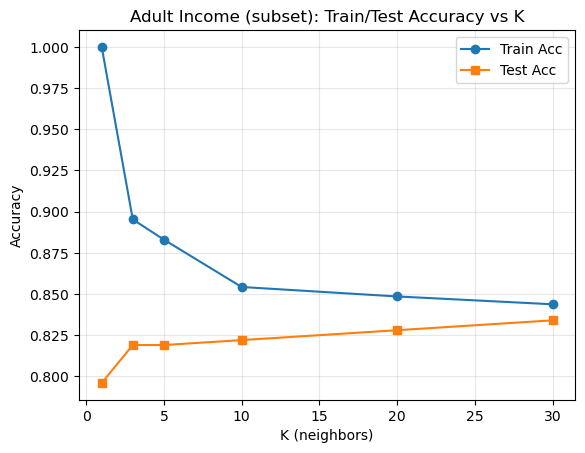

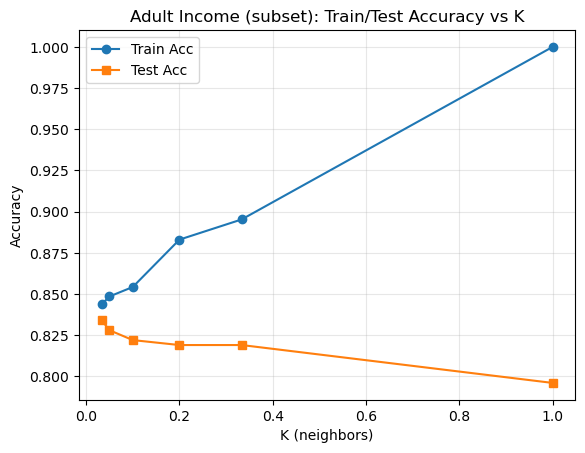

In [11]:

# Load
adult = fetch_openml("adult", version=2, as_frame=True)
X = adult.data
y = (adult.target == ">50K").astype(int)


# Downsample for demo speed
X_small, _, y_small, _ = train_test_split(X, y, train_size=5000,
                                          stratify=y, random_state=42)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_small, y_small,
                                                    test_size=0.2,
                                                    stratify=y_small,
                                                    random_state=42)

# Preprocess
num_cols = X_train.select_dtypes(include=np.number).columns
cat_cols = X_train.select_dtypes(exclude=np.number).columns
preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])
X_train_pre = preprocess.fit_transform(X_train)
X_test_pre  = preprocess.transform(X_test)

# Sweep fewer K values for speed
Ks = [1, 3, 5, 10, 20, 30]
train_acc, test_acc = [], []

for k in Ks:
    print(k)
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_pre, y_train)
    train_acc.append(knn.score(X_train_pre, y_train))
    test_acc.append(knn.score(X_test_pre, y_test))

# Plot
plt.plot(Ks, train_acc, marker="o", label="Train Acc")
plt.plot(Ks, test_acc, marker="s", label="Test Acc")
plt.xlabel("K (neighbors)")
plt.ylabel("Accuracy")
plt.title("Adult Income (subset): Train/Test Accuracy vs K")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot
plt.plot([1/k for k in Ks] , train_acc, marker="o", label="Train Acc")
plt.plot([1/k for k in Ks] , test_acc, marker="s", label="Test Acc")
plt.xlabel("K (neighbors)")
plt.ylabel("Accuracy")
plt.title("Adult Income (subset): Train/Test Accuracy vs K")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Quick Demo: k-Fold Cross-Validation (CV)

So far, we checked how accuracy changes with K in KNN.  
Now we show **k-fold cross-validation** as a systematic way to estimate performance:

- Split the dataset into **k folds** (here k=3) with stratified sampling.  
- Each fold is used once as validation, while the others train the model.  
- Report the **mean ± std accuracy** to assess stability.  

We compare:
1. **Logistic Regression** – linear baseline.  
2. **KNN (K=10)** – local, flexible method.  

This shows how CV avoids overfitting to a single train/test split.  



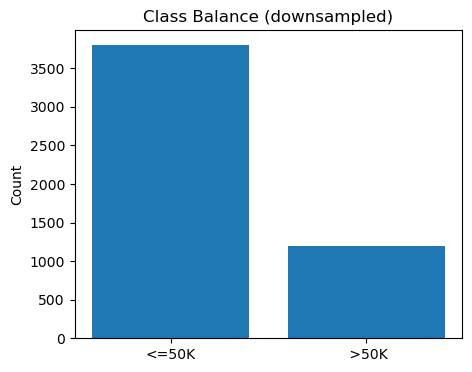

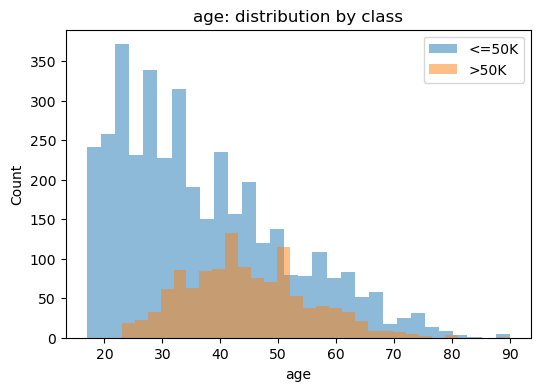

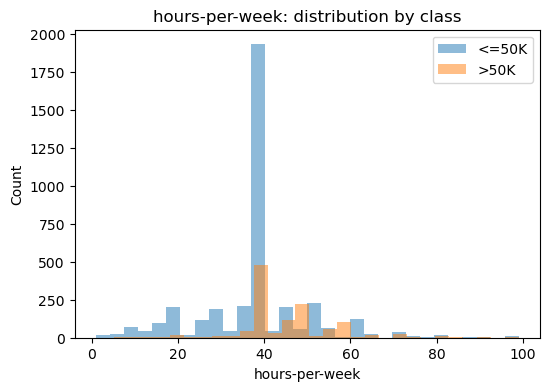

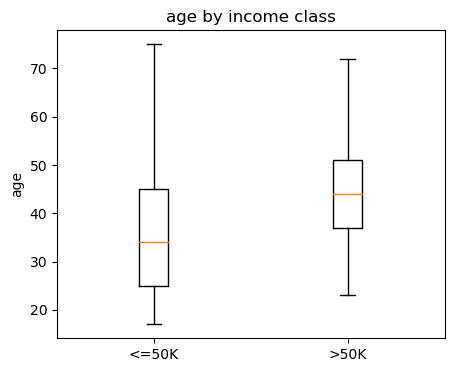

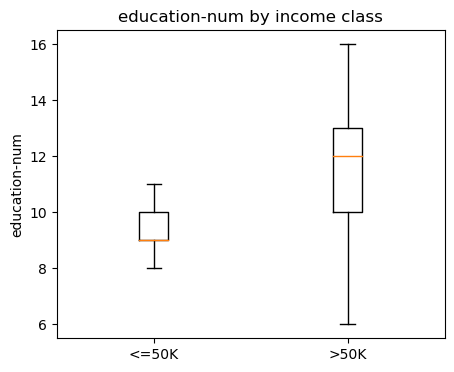

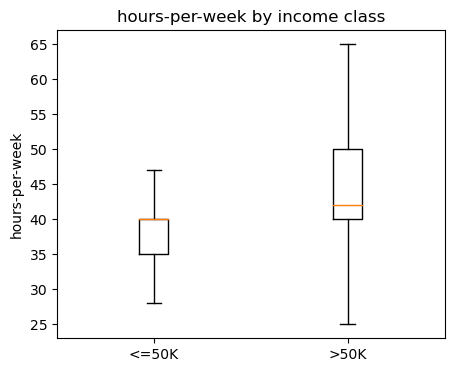

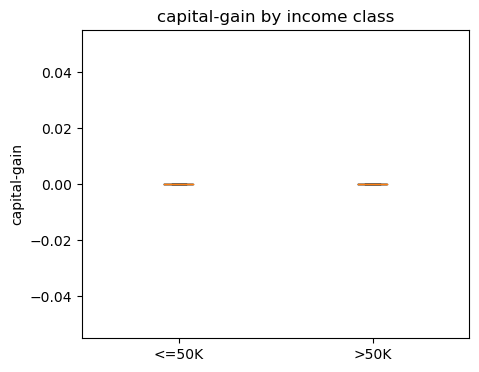

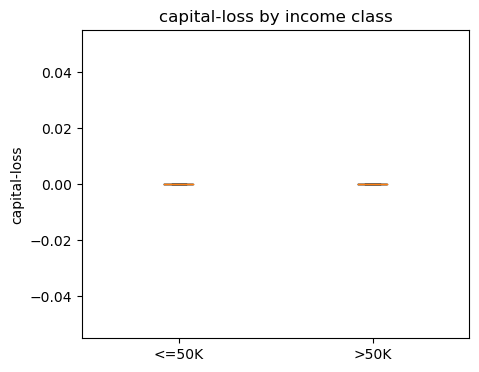

Logistic CV Accuracy: mean=0.846, std=0.012
KNN (K=10) CV Accuracy: mean=0.828, std=0.008


In [12]:
# EDA uses the downsampled DataFrame and labels you already created
df_small = X_small.copy().reset_index(drop=True)
df_small["income_high"] = y_small.values  # 1 => >50K

# ---- Class balance
counts = df_small["income_high"].value_counts().sort_index()
plt.figure(figsize=(5,4))
plt.bar(["<=50K"," >50K"], counts.values)
plt.title("Class Balance (downsampled)")
plt.ylabel("Count")
plt.show()

# ---- Overlayed histograms for two numeric features
def overlay_hist(col, bins=30):
    plt.figure(figsize=(6,4))
    vals0 = df_small.loc[df_small["income_high"]==0, col].dropna().values
    vals1 = df_small.loc[df_small["income_high"]==1, col].dropna().values
    plt.hist(vals0, bins=bins, alpha=0.5, label="<=50K")
    plt.hist(vals1, bins=bins, alpha=0.5, label=">50K")
    plt.title(f"{col}: distribution by class")
    plt.xlabel(col); plt.ylabel("Count"); plt.legend()
    plt.show()

overlay_hist("age")
overlay_hist("hours-per-week")

# ---- Simple boxplots for a few numeric features vs class
numeric_show = ["age", "education-num", "hours-per-week", "capital-gain", "capital-loss"]
for col in numeric_show:
    data0 = df_small.loc[df_small["income_high"]==0, col].dropna().values
    data1 = df_small.loc[df_small["income_high"]==1, col].dropna().values
    plt.figure(figsize=(5,4))
    plt.boxplot([data0, data1], labels=["<=50K", ">50K"], showfliers=False)
    plt.title(f"{col} by income class")
    plt.ylabel(col)
    plt.show()

# Build a fresh preprocessor for CV (no leakage)
num_cols_all = X_small.select_dtypes(include=np.number).columns
cat_cols_all = X_small.select_dtypes(exclude=np.number).columns

pre_cv = ColumnTransformer([
    ("num", StandardScaler(), num_cols_all),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_all)
])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Logistic baseline (solver that supports sparse)
log_pipe = Pipeline([
    ("pre", pre_cv),
    ("log", LogisticRegression(max_iter=1000, solver="liblinear"))
])
log_scores = cross_val_score(log_pipe, X_small, y_small, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"Logistic CV Accuracy: mean={log_scores.mean():.3f}, std={log_scores.std():.3f}")

# KNN with fixed K=10
knn_pipe = Pipeline([
    ("pre", pre_cv),
    ("knn", KNeighborsClassifier(n_neighbors=10, n_jobs=-1))
])
knn_scores = cross_val_score(knn_pipe, X_small, y_small, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"KNN (K=10) CV Accuracy: mean={knn_scores.mean():.3f}, std={knn_scores.std():.3f}")
